In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine

In our classes we will use TensorFlow and Keras, however, a project can be done with any technology you want. You can even use pure NumPy and implement neural networks by yourself or write it in C or Assembler.

TensorFlow by default allocates nearly all available memory on the GPU. It's wise to set the memory_growth parameter then it will take just as much memory as needed.

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

Before we jump to neural networks let's start with a single perceptron. It's a simple mathematical model that calculates a weighted sum and applies a selected function called an activation function.

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=(2,)))
# that's how we create a single layer. First parameter specifies how many neurons we want, since we want to have
# a single perceptron we use 1. Then we specify the input shape so bascially the number of variables
model.summary()

Above we created a simple neural network with just one neuron accepting input consisting of two values. As you can see such a network/perceptron has 3 parameters. Two of them are the weights associated with each input. Additionally, there is one more parameter called bias. It can be treated as a weight associated with an additional constant input equal to one.

The formula for a single perceptron looks as follows.
$$ \sum (x_i*w_i) + bias$$

Let's check if it really works

In [ ]:
model.weights

Above you should see two weights as kernel and one bias. These weights are randomly initialized. Let's see if the formula is correct.

In [ ]:
x = np.array([[2,1]]) # dummy input for calculations
print("Model prediction:", model.predict(x))
print("Manual calculations:", x @ model.weights[0].numpy() + model.weights[1].numpy())

Method predict simply run neural network with given input.

Seems it works since the results are the same, btw @ is an operator for matrix multiplication. If you don't trust it you can write it step by step with scalar multiplication.

OK but what about an activation function?

That's right, here we just used linear function f(x) = x, but in general, you can use whatever function you want e.g. tanh. It's applied after the weighted sum. So let's update our formula and try it once again.
$$ f(\sum (x_i*w_i) + bias)$$

In [ ]:
model = Sequential()
model.add(Dense(1, 'tanh', input_shape=(2,))) # the second parameter specifies the activation function
model.summary()

In [ ]:
model.weights

In [ ]:
x = np.array([[2,1]]) # dummy input for calculations
print("Model prediction:", model.predict(x))
print("Manual calculations:", x @ model.weights[0].numpy() + model.weights[1].numpy())

Now result of predict is different than our manual computations. That's because in predict a tanh activation function is used. Let's add tanh to our formula and see if the results match

In [ ]:
print("Improved manual calculations:", np.tanh(x @ model.weights[0].numpy() + model.weights[1].numpy()))

The results might not be exactly the same due to numerical errors and the implementation of tanh, but it's clear it works.

So why do we want to use different activation functions and which of them to use?

We will return to that question later on.


Now let's talk about those weights and how to obtain them.
Well, the idea is simple. Firstly you need a training set with predictors ($x$) and target ($y$). In our example let's try to predict the price of a flat ($y$) based on its area ($x$). Of course, more than one feature can and should be used e.g. floor, year, district, ..., but for clarity, let's use a single feature.

In [ ]:
np.random.seed(41)
x = np.random.rand(200,1)*20+50

In [ ]:
np.random.seed(27)
y = .5*x + np.random.rand(*x.shape)*3 + np.log(x-49)*2

In [ ]:
plt.plot(x,y, '.')
plt.xlabel("$m^2$")
plt.ylabel("price in bitcoins")
plt.show()

Ok, we created a dataset (a fake one, but perfect for this exercise). Now let's create a perceptron that will solve this task. Which activation function should be used?

In [ ]:
np.random.seed(0)
model = Sequential()
model.add(Dense(1, input_shape=(1,))) #now we have only one input parameter
model.summary()

In [ ]:
model.predict(x)

In [ ]:
plt.plot(x,y, '.', label='data')
plt.plot(np.sort(x,0), model.predict(np.sort(x,0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

That's our prediction. Probably we are not even close. It's not strange, weights are initialized in a randomized way. What we need now is a measure of this error called a loss function. Once it's defined, the process of training weights is just an optimization task and the goal is to find such weights that minimize the loss function. In fact, any optimization algorithm can be used here including random search - try a lot of random weights and choose the best ones. But in most cases, stochastic gradient descent is used - in this algorithm using derivative iteratively the weights are updated

The first idea might be simply to calculate $prediction - y$. Do you know why it fails? The problem is we will keep a sign so positive and negative errors will cancel each other. We can improve this approach by taking an absolute of it. This metric is called a mean absolute error and again there is one problem. It's not differentiable and some algorithms for optimization require the loss function to be differentiable. That's why we will use the so-called mean squared error $(prediction - y)^2$. It works more or less like mean absolute error + it's differentiable + lower impact of small errors and higher impact of big errors.


In [ ]:
mse = lambda x,y: ((y - x)**2).mean() # our loss function

I said you can use even random search so let's give it a try

In [ ]:
bestWeights = model.get_weights()
pred = model.predict(x, verbose=0)
bestError = mse(y, pred)
bestError

for _ in range(200):
    # generate random weights
    weights = [np.random.randn(1,1), np.random.randn(1)]
    # use them in the model
    model.set_weights(weights)
    pred = model.predict(x, verbose=0)
    # evaluate the weights
    err = mse(y, pred)
    if err < bestError:
        bestError = err
        bestWeights = model.get_weights()
        print("Best score so far:", err)


In [ ]:
model.set_weights(bestWeights)
plt.plot(x,y, '.', label='data')
plt.plot(np.sort(x,0), model.predict(np.sort(x,0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

Ok, it looks better but there should be a better way than a random search. Of course, there is. As I said before, any optimization technique can be used here but in most cases, a version of stochastic gradient descent is used. Here we take advantage of a differentiable loss function and iteratively step by step change the weights in a direction set by gradient descent.

There are two parameters related to optimizing neural network weights using this algorithm: number of epochs and batch size. The batch size determines the number of rows used for one update of weights. The general rule is the higher the better. The number of epochs determines how many times we will go through the whole dataset in the training process. The total number of weights updates is size of data / batch size * number of epochs

This function is already implemented so we just have to call the fit function. Before we have to call a compile method where we say which loss function should be used and if we want to collect some additional metrics

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(loss='mse', metrics=['mae'])
history = model.fit(x,y, epochs=300, batch_size=16)
pd.DataFrame(history.history).plot()
plt.grid()
plt.yscale('log')
plt.show()

How to adjust the number of epochs? When you look at the history you should be able to determine when it doesn't make much sense to continue the optimization process. At some point, there is no longer any progress. We can use so-called callbacks - functions executed at various stages of the model training e.g. after each epoch. We can monitor the progress and stop learning when it's not progressing anymore. Such a callback is already implemented and is called EarlyStopping. It can be used together with the ReduceLROnPlateau callback. Before stopping the learning phase first it reduces the learning rate allowing the reduction of loss function even more.

In [ ]:
early = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)

model = Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(loss='mse', metrics=['mae'])
history=model.fit(x,y, epochs=1000, batch_size=16, callbacks=[early, reduce])
history = pd.DataFrame(history.history).plot()
plt.grid()
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(x,y, '.', label='data')
plt.plot(np.sort(x,0), model.predict(np.sort(x,0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

The result is not perfect but with such a model it cannot be better. This model can return only linear output and there isn't a line that will fit much better to the data we have. What we have to do is to extend the model. Let's create a neural network with more than one neuron. Typically in classical neural networks neurons are organized in layers. Outputs of the previous layer is an input for the next layer. All inputs are connected to each neuron from a given layer thus we call such architecture fully connected or dense.


Here we can return to the activation functions.

First, let's list the most popular functions

In [ ]:
print("linear")
r = np.linspace(-7,7)
plt.plot(r,r)
plt.grid()
plt.show()
print("tanh")
plt.plot(r, np.tanh(r))
plt.grid()
plt.show()
print("sigmoid")
plt.plot(r, 1/(1 + np.exp(-r)))
plt.grid()
plt.show()
print("relu")
plt.plot(r, np.where(r<0,0,r))
plt.grid()
plt.show()
print("leakyrelu")
plt.plot(r, np.where(r<0,r*.1,r))
plt.grid()
plt.show()

Now how to decide which one to use. As you probably noticed some functions have a limited range of values e.g. sigmoid returns values from 0 to 1 hence it's a perfect option when the output should be treated as a probability.

In dense layers it doesn't make much sense to use linear activation. Do you know why? What's a linear transformation of linear transformation?

Good default choice is relu

The process of weight selection uses the derivative of an activation function. As you probably noticed for most of them derivative is close to zero for big positive and negative values. That's why we want to stay close to 0. To achieve that it's a good practice to introduce a data scaling process. It's a good idea to try different options, but classical standardization should be enough in most cases

In [ ]:
ss_x = StandardScaler()
ss_y = StandardScaler()

transformed_x = ss_x.fit_transform(x)
transformed_y = ss_y.fit_transform(y)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,))) # 64 neurons in the first layer
model.add(Dense(1)) # no need to specify input shape. Why?   -> the each next layer is directly connected with previous ones. program knows that input here is the output from previous

model.compile(loss='mse', metrics=['mae'])

early = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)  #If after  15 epochs theres no improvement, stop, restore to weights since which it stopped improving
reduce = ReduceLROnPlateau(monitor='loss', patience=6)  #Reduce learning rate after 6 epochs of no improvement

model.fit(transformed_x,transformed_y, epochs=500, batch_size=16, callbacks=[early, reduce])

In [ ]:
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(np.sort(transformed_x, 0), model.predict(np.sort(transformed_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

You might wonder why do we use sort for plotting the prediction. Well it's just to draw a nice line. When the points are in a random order and we plot lines between them it might be quite chaotic.

In [ ]:
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(transformed_x, model.predict(transformed_x), label='prediction')
plt.legend()
plt.grid()
plt.show()

To avoid it we can just plot points, but a line looks better

In [ ]:
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(transformed_x, model.predict(transformed_x), '.', label='prediction')
plt.legend()
plt.grid()
plt.show()

# Task 1
What's the best architecture? Play here https://playground.tensorflow.org/

Depends on dataset. For more clearly defined and convex, the less layers the better. For spiral it works only with more neurons and first layers that are more complicated, so that points have a chance of getting to the right classification by small change. Sigmoid didnt work well, mostly tanh and relu.


# Task 2
Try different architectures. Use different number of layers, neurons, activation functions

In [ ]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(1,))) # 64 neurons in the first layer
model.add(Dense(64, activation='leaky_relu')) # 64 neurons in the first layer
model.add(Dense(1)) # no need to specify input shape. Why?   -> the each next layer is directly connected with previous ones. program knows that input here is the output from previous

model.compile(loss='poisson', metrics=['mae'])  

early = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)  #If after  15 epochs theres no improvement, stop, restore to weights since which it stopped improving
reduce = ReduceLROnPlateau(monitor='loss', patience=6)  #Reduce learning rate after 6 epochs of no improvement

model.fit(transformed_x,transformed_y, epochs=500, batch_size=16, callbacks=[early, reduce])
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(np.sort(transformed_x, 0), model.predict(np.sort(transformed_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

## Overfitting 
- no callbacks
- too many layers for so simple data

In [ ]:
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(1,))) # 64 neurons in the first layer
model.add(Dense(64, activation='leaky_relu')) # 64 neurons in the first layer
model.add(Dense(64, activation='sigmoid')) # 64 neurons in the first layer
model.add(Dense(64, activation='tanh')) # 64 neurons in the first layer
model.add(Dense(64, activation='relu')) # 64 neurons in the first layer
model.add(Dense(1)) # no need to specify input shape. Why?   -> the each next layer is directly connected with previous ones. program knows that input here is the output from previous

model.compile(loss='mse', metrics=['mae'])  

model.fit(transformed_x,transformed_y, epochs=500, batch_size=16, verbose=0)
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(np.sort(transformed_x, 0), model.predict(np.sort(transformed_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

Selecting the best number of layers and neurons is an optimization task itself. There are no strict rules. In general, you should increase the number of neurons as long as it improves the results. Be aware of overfitting - model learning noise in the data. Always split dataset to train, validation and training.

Remember even the most complex network works still like a single perceptron - it's just an equation with weights determined using an optimization algorithm.

Lifehack: since selecting architecture is an optimization task we can use an optimization algorithm to solve it. The most obvious representation would be a vector of size equal to the maximum number of layers we want and each element representing the number of neurons in such a layer. There are a few problems with this approach - it doesn't make sense to have neurons in the next layer if we have 0 neurons in the previous which is allowed in this representation. Removing 0 from the considered range is an option but then we will fix the number of layers. Also in most cases, it's not recommended to increase the number of neurons in the next layer. To avoid these issues we can change the representation. The first element will still be the number of neurons in the first layer, but all remainings will be the number from 0 to 1 meaning the fraction of neurons from the previous layer used in this layer. For example $[64, 1, .5, .5, 0, 0]$ would mean architecture with 4 layers with 64, 64, 32, and 16 neurons.

To avoid overfitting we split our dataset to training, validation, and test sets. It's a good practice in most cases to shuffle the data  since the initial order might have some problems. For example data can be sorted by a target value. Then if we split it in half, the testing set might contains target that are not in the training set

In [ ]:
np.random.seed(31)
idx = np.arange(len(x))
np.random.shuffle(idx)
idx

In [ ]:
train = idx[:int(.8*len(x))]
val = idx[int(.8*len(x)):int(.9*len(x))]
test = idx[int(.9*len(x)):]

In [ ]:
train_x, train_y = transformed_x[train], transformed_y[train]
val_x, val_y = transformed_x[val], transformed_y[val]
test_x, test_y = transformed_x[test], transformed_y[test]

What's the problem here? Well it's not a big issue, but data from validation and test sets should not be used to determine scaling parameters. So the scaler should be fit on the training data and then applied to validation and test datasets. Can you do it now?

In [ ]:
ss_x = StandardScaler()
ss_y = StandardScaler()

#Train on train set
train_x = ss_x.fit_transform(train_x)
train_y = ss_y.fit_transform(train_y)

#Apply to val and test
val_x = ss_x.transform(val_x)
val_y = ss_y.transform(val_y)
test_x = ss_x.transform(test_x)
test_y = ss_y.transform(test_y)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mae'])

early = EarlyStopping(patience=15, restore_best_weights=True) # we don't specify monitor, by default it's val_loss
reduce = ReduceLROnPlateau(patience=6)

model.fit(train_x,train_y, validation_data=(val_x, val_y), epochs=500, batch_size=16, callbacks=[early, reduce])

In [ ]:

plt.plot(test_x,test_y, '.', label='data')
plt.plot(np.sort(test_x, 0), model.predict(np.sort(test_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

There are two popular functions to create a neural network model. For simple architectures Sequential can be used. For more complex Model is a suitable choice.


In the sequential model, we assume layers are executed sequentially one by one. In Model, we can create architectures with different connections, multiple inputs or outputs.

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(32, activation='relu', input_shape=(1,)))
model.add(Dense(16, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

In [ ]:
plot_model(model)

In [ ]:
inputLayer = Input(shape=(1,))
dense1 = Dense(64, activation='relu')(inputLayer)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dense4 = Dense(1, activation='relu')(dense3)
model = Model(inputs=inputLayer, outputs=dense4)

In [ ]:
plot_model(model)

In [ ]:
inputLayer = Input(shape=(1,))
dense1 = Dense(64, activation='relu')(inputLayer)
dense2 = Dense(32, activation='relu')(dense1)
concat = Concatenate()([dense1, dense2])
dense3 = Dense(16, activation='relu')(concat)
dense4 = Dense(1, activation='relu')(dense3)
model = Model(inputs=inputLayer, outputs=dense4)

In [ ]:
plot_model(model)

# Task 3
Create a model with two inputs, first processed by three Dense layers, second by two Dense layers, then concatenat them, process by two Dense layers and split it to two outputs

In [ ]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))

dense1_1 = Dense(64, activation='relu')(input1)
dense1_2 = Dense(32, activation='relu')(dense1_1)
dense1_3 = Dense(16, activation='relu')(dense1_2)
dense2_1 = Dense(64, activation='relu')(input2)
dense2_2 = Dense(32, activation='relu')(dense2_1)

concat = concatenate([dense1_3, dense2_2])

dense3 = Dense(1, activation='relu')(concat)
dense4 = Dense(1, activation='relu')(dense3)

output1 = Dense(1, activation='linear')(dense4)
output2 = Dense(1, activation='linear')(dense4)

model = Model(inputs=[input1, input2], outputs=[output1, output2])
# model.summary()
plot_model(model)

Data generators are useful tools for neural network training. It allows to create data separately for each batch. Thanks to that there is no need to load all the data to the memory, which can be an issue for example when dealing with images. Also when we don't have data but a function creating data then instead of generating a fixed number of rows in advance a data generator can be used. It's also useful for the data augmentation process.

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size, shuffle=True):
        self.x = x
        self.y = y
        self.indexes = np.arange(len(y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch.
        # During training and prediction this function will be called in range(0, __len__())
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx):
        X = np.empty((self.batch_size, 1))
        y = np.empty((self.batch_size), )

        for i, ID in enumerate(idx):
            # Store sample
            X[i,] = self.x[ID]

            # Store class
            y[i] = self.y[ID]

        return X, y

In [ ]:
trainGenerator = DataGenerator(train_x, train_y, 16)
valGenerator = DataGenerator(val_x, val_y, 1, shuffle=False)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mae'])

early = EarlyStopping(patience=15, restore_best_weights=True) # we don't specify monitor, by default it's val_loss
reduce = ReduceLROnPlateau(patience=6)

model.fit(trainGenerator, validation_data=valGenerator, epochs=500, batch_size=16, callbacks=[early, reduce])

In [ ]:
plt.plot(test_x,test_y, '.', label='data')
plt.plot(np.sort(test_x, 0), model.predict(np.sort(test_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

Of course, this generator doesn't make much sense since the data are already in the memory and we don't do anything with them. It's just a template you can use later when it's really needed.

# Task 4
Predict the quality of wine using neural network.
 - Treat target as continuous.
 - Treat target as discrete classes.

In [ ]:
data = load_wine()

In [ ]:
X = data['data']
y = data['target']
# y.value_counts(normalize=True).round(3)

In [ ]:
np.isnan(X).sum()
np.bincount(y)/len(y)

In [ ]:
y

Here spliting into train, val, and test sets without shuffling might not be the best idea

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape)


ss_x = StandardScaler()
#Train on train set, apply to test
X_train = ss_x.fit_transform(X_train)
X_test = ss_x.transform(X_test)


model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(13,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])

early = EarlyStopping(patience=50, restore_best_weights=True, monitor='accuracy') # we don't specify monitor, by default it's val_loss
reduce = ReduceLROnPlateau(patience=50, monitor='loss')

model.fit(X_train, y_train, epochs=500, batch_size=16, callbacks=[early, reduce])
#, validation_data=(X_val, y_val)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Project


In [ ]:
df = pd.DataFrame({'pActive': [0.7, 0.2], 'popularity': [0.1, 0.4]})
df

Consider a simplified model for the election of, for example, the mayor of a city. In our case we have 12 potential candidates. Each of them has assigned a probability $pActive$ determining the chances of running in the election - this consists of, for example the chance of collecting signatures, being nominated by their party, etc.

In addition, we also determined the popularity of each candidate.
The probability of winning an election is equal to the ratio of its
popularity to the sum of the popularity of all active candidates
participating in the election.

Example:

With two candidates having $pActive$ 0.7 and 0.2 and $popularity$ 0.1 and 0.4 respectively there are 4 possible sceanrios:

 - nobody participaring in the elections p = (1-0.7) * (1-0.2) = 0.24
 - just candidate A p = 0.7 * (1-0.2) = 0.56
 - just candidate B p = (1-0.7) * 0.2 = 0.06
 - both candidates p = 0.7 * 0.2 = 0.14

In the first scenario there are no candidates so nobody wins the election. In the second and third case there is just once candidate so with 100% probability she/he wins. The last scenario is the most complex and we have to account for popularity and candidate A has 20% chances of wining and B 80%. Combining all scenarios

 - candidate A: 0.56 * 100% + 0.14 * 20% = 58.8%
 - candidate B: 0.06 * 100% + 0.14 * 80% = 17.2%

We can write a function to calculate it


In [ ]:
def getProbability(df):
    combinations = np.indices((2,) * len(df)).reshape(len(df), -1).T.astype(int)
    p = np.maximum((1-combinations)*(1-df.pActive.values), (combinations*df.pActive.values)).prod(1)
    prob = (combinations * df.popularity.values)[1:] / (combinations * df.popularity.values).sum(1).reshape((-1,1))[1:]
    x=(p.reshape((-1,1))[1:] * prob)

    return x.sum(axis=0)

In [ ]:
getProbability(df)

In [ ]:
np.random.seed(44)
df = pd.DataFrame({'pActive': np.random.rand(23), 'popularity': np.random.rand(23)})
df

In [ ]:
getProbability(df)

It might take longer when more candidates are considered. Imagine you are a party leader and you want to determine who shall be your candidate. You have to solve an optimization problem where this function will be executed hundreds of times thus we want to make it faster.

Your task is to create a neural network estimating function $getProbability$, while being much faster. You can assume the maximum number of candidates is 16 and the minimal is 1. $pActive$ is in range from 0 to 1 $popularity$ is greater than 0 without an upper limit. Keep in mind it's possible no candidate will participate in the election (scenario 1 in the example above).
Try to avoide using pre- and post-processing and do as much computations as possible inside the neural network

You can test your results here https://www.kaggle.com/t/0ab6861855f141969f4755129a6c5bca

Send your result by 4th November to grzegorz.miebs@cs.put.poznan.pl, start the email subject with [DL], there should be a function that reads a pickled list of DataFrames and produces a .csv file with probabilities.


In [ ]:
# in/output size. propper output acivation that will model probability not summing to 1. time complexity important. 

#### Data generator for handling computations in batches

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import Sequence, plot_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Dropout


c:\Users\mary9\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\mary9\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def getProbability(df):
    combinations = np.indices((2,) * len(df)).reshape(len(df), -1).T.astype(int)
    p = np.maximum((1 - combinations) * (1 - df.pActive.values), (combinations * df.pActive.values)).prod(1)
    prob = (combinations * df.popularity.values)[1:] / (combinations * df.popularity.values).sum(1).reshape((-1, 1))[1:]
    x = (p.reshape((-1, 1))[1:] * prob)

    return x.sum(axis=0)

class DataGenerator(Sequence):
    def __init__(self, x, batch_size=32, shuffle=True):
        self.x = x  # Features: assumes shape (num_samples, 2)
        self.indexes = np.arange(len(x))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx):
        # Create empty arrays for the batch
        X = np.empty((self.batch_size, 2))  # Assuming 2 features: pActive and popularity
        y = np.empty((self.batch_size,))     # Assuming y is one-dimensional (continuous probabilities)

        for i, ID in enumerate(idx):
            # Store sample
            X[i, :] = self.x[ID]

        # Generate probabilities for the entire batch using getProbability
        df_batch = pd.DataFrame(X, columns=['pActive', 'popularity'])  # Create DataFrame from current batch
        y = getProbability(df_batch)  # Get probabilities for the batch

        return X, y


##### Creating train data

In [3]:
np.random.seed(44)
num_rows = 1000
X = pd.DataFrame({
    'pActive': np.random.rand(num_rows),  # Random values between 0 and 1
    'popularity': np.random.rand(num_rows)   # Random values for popularity (0 to 100)
}).values


train_gen = DataGenerator(X[:int(0.8*num_rows)], batch_size=16, shuffle=False)
val_gen = DataGenerator(X[int(0.8*num_rows):], batch_size=16, shuffle=False)
# print(train_gen.__getitem__(0))
# print(val_gen.__getitem__(0))

##### Model

In [21]:
inputLayer = Input(shape=(2,), name='input1')

hidden1 = Dense(96, activation='relu')(inputLayer)
hidden2 = Dense(96, activation='relu')(hidden1)
dropout1 = Dropout(0.5)(hidden2)
hidden3 = Dense(48, activation='relu')(dropout1)
# hidden4 = Dense(8, activation='relu')(hidden3)
# hidden3 = Dense(4, activation='relu')(hidden2)

output = Dense(1, activation='sigmoid')(hidden3)
model = Model(inputs=inputLayer, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])


##### Fitting with early stopping patience 15

In [22]:
early = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_mse')

history = model.fit(train_gen, validation_data=val_gen, epochs=100, batch_size=16, callbacks=[early], verbose=1)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1187 - mae: 0.3136 - mse: 0.1187 - val_loss: 0.0081 - val_mae: 0.0701 - val_mse: 0.0081
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0076 - mae: 0.0686 - mse: 0.0076 - val_loss: 0.0071 - val_mae: 0.0645 - val_mse: 0.0071
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0065 - mae: 0.0618 - mse: 0.0065 - val_loss: 0.0069 - val_mae: 0.0628 - val_mse: 0.0069
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0066 - mae: 0.0621 - mse: 0.0066 - val_loss: 0.0065 - val_mae: 0.0603 - val_mse: 0.0065
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0058 - mae: 0.0566 - mse: 0.0058 - val_loss: 0.0057 - val_mae: 0.0539 - val_mse: 0.0057
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0050 - mae: 0.0521 - mse: 0.0050 - val_loss: 0.0030 - val_mae: 0.0356 - val_mse: 0.0030
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0025 - mae: 0.0356 - mse: 0.0025 - val

#### Visualize the training history

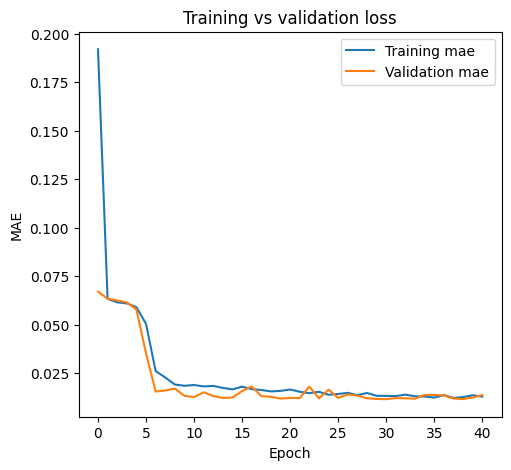

In [15]:

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
# plt.plot(history.history['mse'], label='mse mae')
plt.title('Training vs validation loss')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

#### Check performance of the model

In [16]:
np.random.seed(5)
X = pd.DataFrame({'pActive': np.random.rand(16), 
                  'popularity': np.random.rand(16)})


y_true = getProbability(X)
y_pred = model.predict(X)
diff = np.abs(y_pred.flatten() - y_true.flatten())


comparison_df = pd.DataFrame({
    'Predicted Probabilities': y_pred.flatten(),
    'Actual Probabilities': y_true.flatten(),
    'Difference': diff
})
print(comparison_df)


# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
    Predicted Probabilities  Actual Probabilities  Difference
0                  0.022296              0.027900    0.005605
1                  0.063183              0.086632    0.023449
2                  0.029682              0.037169    0.007487
3                  0.131545              0.177764    0.046219
4                  0.063501              0.088718    0.025217
5                  0.037925              0.053293    0.015369
6                  0.051989              0.072443    0.020454
7                  0.029994              0.042798    0.012804
8                  0.022564              0.030446    0.007882
9                  0.005708              0.008844    0.003136
10                 0.002918              0.004315    0.001398
11                 0.152937              0.216584    0.063646
12                 0.092119              0.118086    0.025967
13                 0.006136              0.009601    0.003465
14                 0.011507     

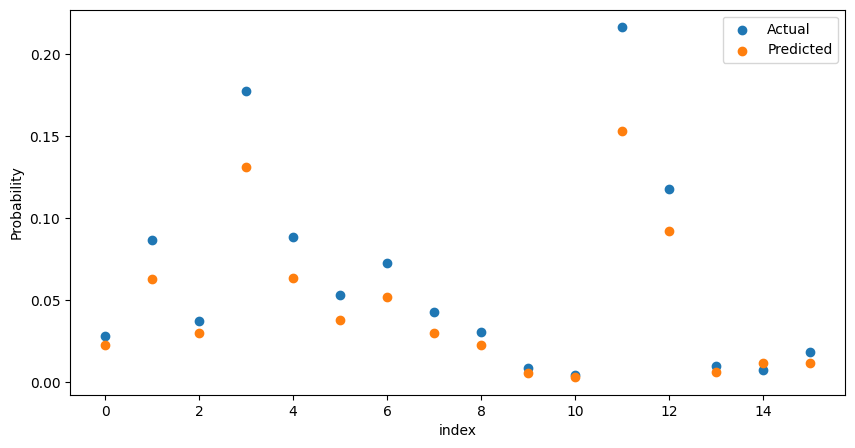

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(X.index ,y_true, label='Actual')
plt.scatter(X.index, y_pred, label='Predicted')
plt.xlabel('index')
plt.ylabel('Probability')
plt.legend()
plt.show()

## Pickle problem

In [18]:
import pickle

# Replace 'your_file.dat' with the path to your .dat file
with open('test_x.dat', 'rb') as file:
    data = pickle.load(file)

# Now, 'data' contains the deserialized object from the .dat file
# print(data)
for i, df in enumerate(data):
    globals()[f'test_{i}'] = df[['pActive', 'popularity']]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


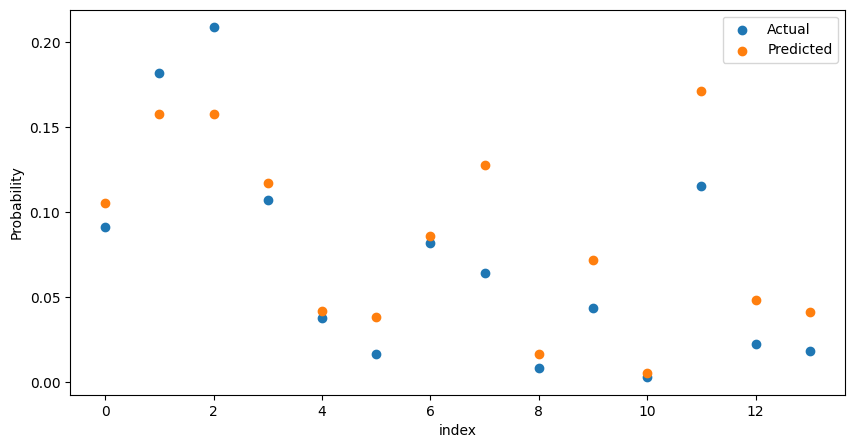

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


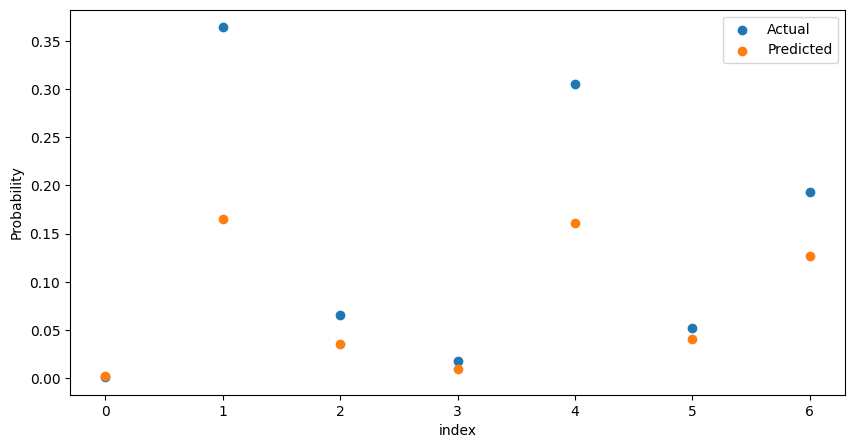

In [19]:
y_pred = model.predict(test_0)
y_true = getProbability(test_0)

plt.figure(figsize=(10, 5))
plt.scatter(test_0.index ,y_true, label='Actual')
plt.scatter(test_0.index, y_pred, label='Predicted')
plt.xlabel('index')
plt.ylabel('Probability')
plt.legend()
plt.show()
y_pred = model.predict(test_3)
y_true = getProbability(test_3)

plt.figure(figsize=(10, 5))
plt.scatter(test_3.index ,y_true, label='Actual')
plt.scatter(test_3.index, y_pred, label='Predicted')
plt.xlabel('index')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Define a function to build the model, taking hyperparameters as input
# def build_model(hp):
#     model = Sequential()
#     model.add(Input(shape=(2,), name='input1'))

#     # Tune number of units in each dense layer
#     units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
#     model.add(Dense(units1, activation='relu'))
    
#     units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
#     model.add(Dense(units2, activation='relu'))
    
#     # Tune dropout rate
#     dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
#     model.add(Dropout(dropout_rate))

#     units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
#     model.add(Dense(units3, activation='relu'))
    
#     model.add(Dense(1, activation='sigmoid'))

#     # Tune learning rate
#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mae', 'mse'])
    
#     return model

# # Instantiate the tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_mae',
#     max_trials=20,
#     executions_per_trial=1,
#     directory='hyperparam_tuning',
#     project_name='nonlinear_function_approximation'
# )

# # Define early stopping callback
# early_stop = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# # Perform hyperparameter search
# tuner.search(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=1)

# # Retrieve the best model
# best_hp = tuner.get_best_hyperparameters()[0]
# print(f"Best hyperparameters: {best_hp.values}")

# # Train the best model
# best_model = tuner.hypermodel.build(best_hp)
# history = best_model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[early_stop], verbose=1)
#96->128->0.5 drop->48->1, 0.001 lr
